In [1]:
%load_ext autoreload
%autoreload 2

# Using Visibility Graphs to Estimate the Hurst Parameter 

In [2]:
# dict for formatting in references 
# todo copy/paste these into cells
refs = {'lacasa2009':'[Lacasa et al. 2009](https://www.readcube.com/library/ee993268-97d7-4f91-b728-eb1b1ac33f55:f660b4a6-9d04-463a-a31a-dd4a196baeae)'}

In this notebook, we have been introduced to the visibility graph and how such graphs can translate a time series into a network. Also, we have introduced the concept of long memory in time series and how this property can be measured with the Hurst parameter $H$. We have also used the `fbm` codebase to generate time series with different values of $H$. 

In {{refs['lacasa2009']}}, the authors introduce that visibility graphs can be used to esimate the Hurst parameter. In this section, we will replicate these results in Python.

The {{refs['lacasa2009']}} paper shows that the degree distribution of a visibility graph follows a power law, and that the exponent of the degree distribution approximates the Hurst parameter. 

To begin to explore this idea, we can generate FBM series that have different Hurst parameters and plot histograms of the corresponding visibility graphs. We'll use the same `fbm` project introduced earlier, the `build_visibility_graph` module and we will use `networkx` to create graph objects:

In [3]:
from src.fbm.fbm import FBM
from src import build_visibility_graph 
import networkx as nx

Now, we can generate three different FBM series with Hurst parameters 0.25, 0.5 and 0.75:

In [4]:
%%time
# n=1k ~ 30 secs, n=750 ~ 15
graphs = dict()
n = 2000

for hurst in [0.25, 0.5, 0.75]:
    y = FBM(n=n, hurst=hurst, length=1, method='daviesharte').fbm()
    x = list(range(len(y)))
    edges = build_visibility_graph.create_edges(x, y)
    graphs[hurst] = nx.from_edgelist(edges)

CPU times: user 3min 9s, sys: 9.56 ms, total: 3min 9s
Wall time: 3min 9s


Now we have a dict `graphs` with keys that are Hurst parameters and values that are time series with the same Hurst parameter. 

We now build a similar dictionary `degs`, where the values are instead arrays of node degrees:

In [5]:
get_degs = lambda g: [g.degree(x) for x in g.nodes]
degs = {k:get_degs(v) for k,v in graphs.items()}

...and create a simple histogram:

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# create a dict of colors, figure size to use in this section
colors = {0.25:'#31393C', 0.5:'#0070AF', 0.75:'#A31621'}
figsize = (12,5)

@interact
def interact_plot(log=False, h25=True, h50=True, h75=True):
    """Creates histogram of three different degree distributions"""
    global degs
    global colors
    global figsize
    # create base figure and axis
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    # setup data for histogram
    # subset node degree lists based on input args "hxx", i.e. checkboxes
    y = [degs[x] for x, inc_bool in zip([0.25, 0.5, 0.75], (h25, h50, h75)) 
         if inc_bool == True]
    # create labels for legend based on checkboxes
    labs = [x for x, inc_bool in zip([0.25, 0.5, 0.75], (h25, h50, h75)) 
            if inc_bool]
    
    # add the histogram
    bins = np.linspace(0,140,28)
    ax.hist(y, bins, label=labs, log=log, color=[colors[x] for x in labs])
    
    # format various aesthetics and labels
    t = 'Histogram of Node Degree for Visibility Graphs by Hurst Parameter H'
    yl = 'Number of Nodes'; ylab = f'log({yl})' if log else yl
    ax.set(title=t, xlabel='Node Degree', ylabel=ylab)
    ax.xaxis.set(ticks=range(0,145,5))
    ax.legend()
    ax.grid()

interactive(children=(Checkbox(value=False, description='log'), Checkbox(value=True, description='h25'), Check…

The checkboxes can be used to toggle whether or not the y-axis is in log and to select any or all of the three different Hurst parameters 0.25, 0.5 and 0.75. 

By default a simple histogram is plotted, but viewing the histogram in log helps see the difference in the degree distributions:

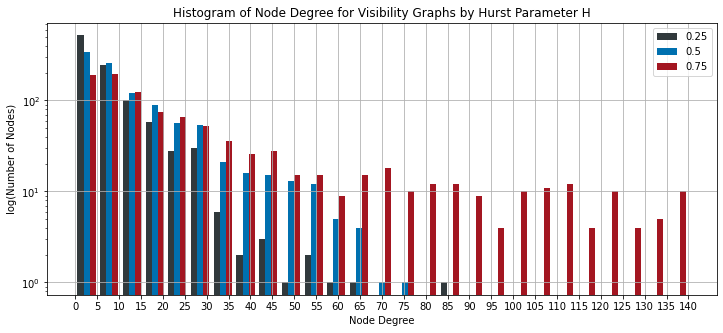

...the persistent series ($H=0.75$, in red above) has many more nodes with degree greater than 75 than does the random series ($H=0.5$, in blue above), and conversely the antipersistent series ($H=0.25$, in black above) has fewer nodes with large degree than does the random series.

In [11]:
def gamma_mle(k):
    """Estimator for power law distribution parameter gamma
    
    From Lacasca 2009 paper. 
    
    """
    n = len(k)
    mk = min(k)
    
    return 1 + n*sum([np.log(i/mk) for i in k])**(-1)

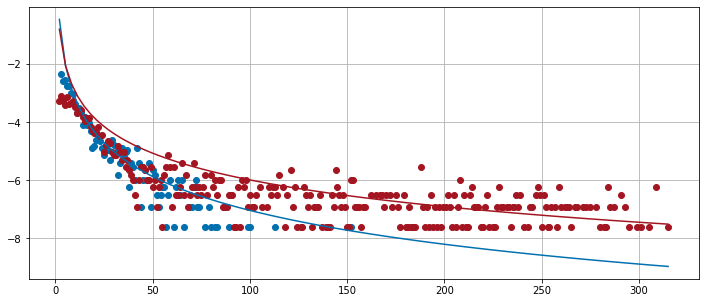

In [94]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
logy = True

def splots(node_degrees):
    """Create scatterplot"""
    d, counts = np.unique(node_degrees, return_counts=True)
    assert not (d != np.sort(d)).sum(), 'Output of np.unique should be sorted'
    deg_counts = dict(zip(d, counts))
    y = [count/len(node_degrees) for d,count in deg_counts.items()][1:]
    if logy:
        y = [np.log(i) for i in y]
    x = list(deg_counts.keys())[1:]
    
    return x, y

h_params = [0.5, 0.75] 

for h in h_params:
    x, y = splots(degs[h])
    ax.plot(x, y, 'ro', color=colors[h])

def theo_curve(gm, x):
    global ax
    global logy
    pw = lambda k: k**(-gm)
    y = [pw(k) for k in x] / sum([pw(k) for k in x])
    if logy:
        y = [np.log(i) for i in y]
    return x, y
    
# plot theoretical quantities 
x = np.linspace(min(x), max(x), 100)
for h in h_params:
    _, y = theo_curve(gamma_mle(degs[h]), x)
    ax.plot(x, y,  color=colors[h])

ax.grid()

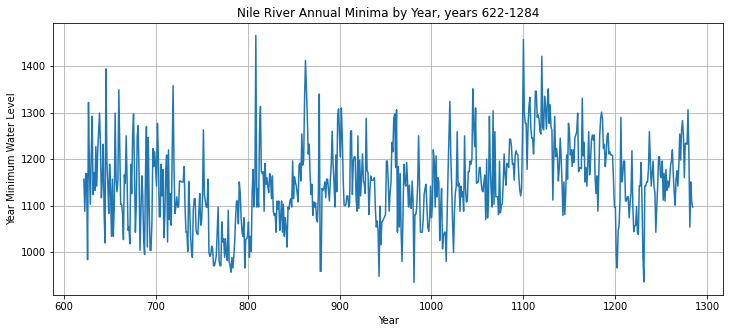

In [60]:
with open('nile.txt', 'r') as f:
    d = [x.strip() for x in f.readlines() if x[0] != '#']

nile_x = [int(x.split(',')[0]) for x in d]
nile_y = [int(y.split(',')[1]) for y in d]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(nile_x, nile_y)
t = f'Nile River Annual Minima by Year, years {min(nile_x):.0f}-{max(nile_x):.0f}'
ax.set(title=t, xlabel='Year', ylabel='Year Minimum Water Level')
ax.grid()

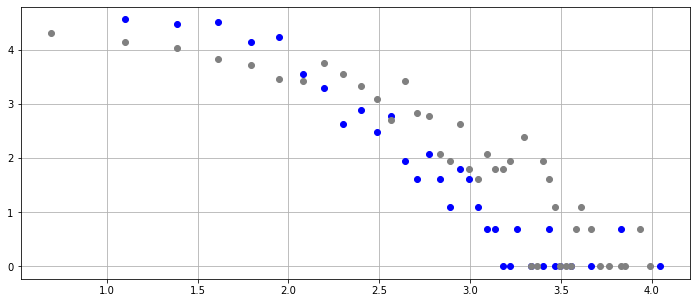

In [120]:
# create graph object from nile data
edges = build_visibility_graph.create_edges(range(len(nile_x)), nile_y)
nile_g = nx.from_edgelist(edges)
get_node_degs = lambda g: [g.degree(i) for i in g.nodes]
nile_node_degs = get_node_degs(nile_g)

# create random data using fbm (i.e. hurst=0.5)
y = FBM(n=len(nile_x), hurst=0.5, length=1, method='daviesharte').fbm()
edges = build_visibility_graph.create_edges(range(len(y)), y)
random_g = nx.from_edgelist(edges)
random_node_degs = get_node_degs(random_g)

def splots(node_degrees):
    """Create scatterplot"""
    d, counts = np.unique(node_degrees, return_counts=True)
    assert not (d != np.sort(d)).sum(), 'Output of np.unique should be sorted'
    deg_counts = dict(zip(d, counts))
    y = [count for d,count in deg_counts.items()][1:]
    x = list(deg_counts.keys())[1:]
    
    return x, y

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

# plot nile distribution
x, y = splots(nile_node_degs)
ax.plot(np.log(x), np.log(y), 'ro', color='blue')

# plot random distribution
x, y = splots(random_node_degs)
ax.plot(np.log(x), np.log(y), 'ro', color='grey')

ax.grid()

In [112]:
len(nile_x)

663

# Scratchpad

In [286]:
raise Exception()

Exception: 

In [12]:
d = """1157 1088 1169 1169  984 1322 1178 1103 1211 1292 1124 1171 1133 1227 1142
1216 1259 1299 1232 1117 1155 1232 1083 1020 1394 1196 1148 1083 1189 1133
1034 1157 1034 1097 1299 1157 1130 1155 1349 1232 1103 1103 1083 1027 1166
1148 1250 1155 1047 1054 1018 1189 1126 1250 1297 1178 1043 1103 1250 1272
1169 1004 1083 1164 1124 1027  995 1169 1270 1011 1247 1101 1004 1004 1065
1223 1184 1216 1180 1142 1277 1206 1076 1076 1189 1121 1178 1031 1076 1178
1209 1022 1220 1070 1126 1058 1216 1358 1184 1083 1097 1119 1097 1097 1153
1153 1151 1151 1151 1184 1097 1043 1043 1002 1152 1097 1034 1002  989 1092
1115 1115 1047 1040 1038 1085 1126 1058 1067 1115 1263 1124 1110 1097 1097
1157 1000  991  995 1013 1007  971  971  980  993 1043 1097  982  971  971
1065 1022 1029  989 1029  995  982 1090  980  971  957  989  966  989 1022
1074 1110 1110 1061 1151 1128 1074 1043 1034 1074  966 1027 1029 1034 1065
 989 1034 1002 1128 1178 1097 1142 1466 1097 1137 1097 1259 1313 1173 1169
1173 1088 1191 1146 1160 1142 1128 1169 1162 1115 1164 1088 1079 1083 1043
1110 1092 1110 1047 1076 1110 1043 1103 1034 1074 1052 1011 1097 1092 1110
1115 1097 1196 1115 1162 1151 1142 1126 1108 1187 1191 1153 1254 1187 1196
1331 1412 1349 1290 1211 1232 1166 1124 1146 1079 1108 1097 1106 1072 1065
1128 1340  959  959 1137 1133 1137 1151 1117 1157 1157 1133 1110 1155 1189
1260 1189 1151 1097 1209 1130 1295 1308 1250 1205 1310 1250 1155 1101 1100
1103 1121 1121 1097 1106 1259 1261 1124 1196 1205 1205 1119 1088 1250 1094
1198 1121 1164 1211 1153 1146 1126 1288 1175 1171 1081 1133 1164 1155 1155
1155 1160 1094 1054 1067 1044  948 1099 1016 1065 1067 1072 1076 1081 1196
1196 1151 1088 1128 1151 1236 1216 1288 1297 1182 1306 1043 1184 1054 1169
1043  980 1072 1189 1151 1142 1193 1151 1097 1144 1097 1094 1153 1108  935
1081 1081 1097 1146 1250 1151 1043 1043 1043 1070 1124 1137 1146 1099 1054
1045 1070 1142 1074 1101 1220 1196 1097 1207 1119 1160 1151 1025 1097 1137
1007 1034 1043 1043  980 1079 1169 1250 1324 1209 1142 1061 1000 1088 1128
1142 1259 1142 1148 1088 1142 1119 1130 1088 1250 1137 1108 1110 1173 1173
1196 1189 1200 1351 1274 1227 1310 1148 1151 1151 1182 1182 1151 1133 1130
1151 1166 1070 1200 1074 1110 1292 1178 1128 1097 1304 1103 1259 1119 1119
1119 1081 1196 1085 1101 1103 1146 1211 1169 1144 1191 1189 1182 1243 1243
1227 1189 1191 1155 1209 1218 1211 1209 1164 1135 1121 1137 1254 1457 1299
1277 1277 1178 1270 1313 1333 1270 1245 1245 1211 1265 1346 1346 1290 1295
1286 1259 1254 1421 1268 1263 1335 1313 1265 1319 1351 1277 1317 1268 1263
1112 1207 1292 1205 1223 1205 1153 1182 1245 1205 1151 1079 1151 1081 1128
1209 1157 1277 1259 1209 1220 1184 1220 1193 1247 1252 1259 1299 1173 1182
1180 1180 1331 1207 1236 1151 1182 1142 1191 1259 1166 1196 1241 1252 1241
1252 1157 1126 1164 1088 1173 1252 1288 1301 1286 1223 1232 1184 1207 1250
1256 1211 1216 1209 1209 1207 1151 1097 1097  989  966 1047 1056 1110 1290
1151 1166 1196 1196 1110 1110 1119 1119 1074 1106 1128 1218 1098 1044 1056
1058 1098 1043 1038 1142 1142 1193 1103  989  936 1142 1142 1151 1151 1180
1259 1196 1142 1169 1196 1142 1128 1043 1097 1142 1205 1205 1164 1160 1196
1112 1169 1110 1178 1133 1153 1139 1155 1187 1196 1220 1166 1128 1101 1157
1175 1142 1187 1254 1198 1263 1283 1252 1160 1234 1234 1232 1306 1205 1054
1151 1108 1097"""

In [243]:
k = degs[0.5]
gamma_mle(k)

1.4643601658003662

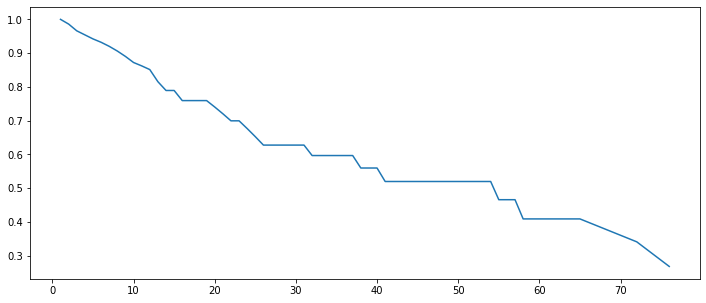

In [278]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

h = 0.5
logy = False
x, counts = np.unique(degs[h], return_counts=True)
assert not (x != np.sort(x)).sum(), 'Output of np.unique should be sorted'
y = [counts[counts >= i].sum()/len(degs[h]) for i in x]
ax.plot(x,y)

In [274]:
len(x)

66

In [271]:
i = 20
counts[counts <= i].sum()

280

In [281]:
y = [len(counts[counts <= count])/len(degs[h]) for d,count in deg_counts.items()][1:]
if logy:
    y = [np.log(i) for i in y]
x = list(deg_counts.keys())[1:]
ax.plot(x, y, 'ro', color=colors[h])

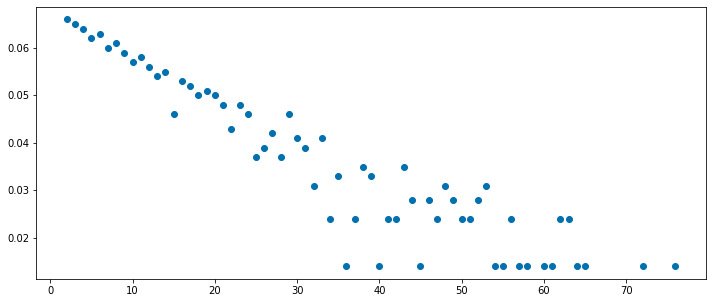

In [282]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

h = 0.5
logy = False
d, counts = np.unique(degs[h], return_counts=True)
assert not (d != np.sort(d)).sum(), 'Output of np.unique should be sorted'
deg_counts = dict(zip(d, counts))
y = [len(counts[counts <= count])/len(degs[h]) for d,count in deg_counts.items()][1:]
if logy:
    y = [np.log(i) for i in y]
x = list(deg_counts.keys())[1:]
ax.plot(x, y, 'ro', color=colors[h])

In [283]:
# plot theoretical quantities 
x = np.linspace(min(x), max(x), 100)
gm = gamma_mle(degs[h])
gm = 0.5
pw = lambda k: k**(-gm)
y = [pw(i) for i in x] 
if logy:
    y = [np.log(i) for i in y]
ax.plot(x, y, color='black')
ax.grid()

In [284]:
def theo_curve(gm, x):
    global ax
    global logy
    pw = lambda k: k**(-gm)
    y = [pw(k) for k in x] / sum([pw(k) for k in x])
    if logy:
        y = [np.log(i) for i in y]
    ax.plot(x, y, color=colors[gm])
    
# plot theoretical quantities 
x = np.linspace(min(x), max(x), 100)
for g in [0.25, 0.5, 0.75]:
    theo_curve(g, x)

ax.grid()

In [204]:
sum(y)

0.9980019980019981

In [207]:
[k**(-gm) for k in x] / sum([k**(-gm) for k in x])

array([0.06551968, 0.04833963, 0.03895824, 0.03295466, 0.02874292,
       0.02560476, 0.02316471, 0.02120618, 0.01959496, 0.01824315,
       0.01709064, 0.01609484, 0.01522468, 0.01445692, 0.01377382,
       0.01316157, 0.01260927, 0.01210819, 0.01165123, 0.01123259,
       0.01084744, 0.01049176, 0.01016216, 0.00985574, 0.00957005,
       0.00930297, 0.00905265, 0.00881751, 0.00859614, 0.00838732,
       0.00818996, 0.00800311, 0.00782591, 0.00765761, 0.00749752,
       0.00734502, 0.00719957, 0.00706067, 0.00692786, 0.00680074,
       0.00667894, 0.0065621 , 0.00644993, 0.00634213, 0.00623844,
       0.00613862, 0.00604245, 0.00594973, 0.00586026, 0.00577387,
       0.00569039, 0.00560967, 0.00545597, 0.00538274, 0.00531176,
       0.00524292, 0.00511129, 0.00498713, 0.00486978, 0.00481348,
       0.00475868, 0.00470531, 0.00465332, 0.00460264, 0.00455324,
       0.00450506, 0.00445805, 0.00441217, 0.00432363, 0.00428089,
       0.00423913, 0.0041983 , 0.00415838, 0.00408113, 0.00404

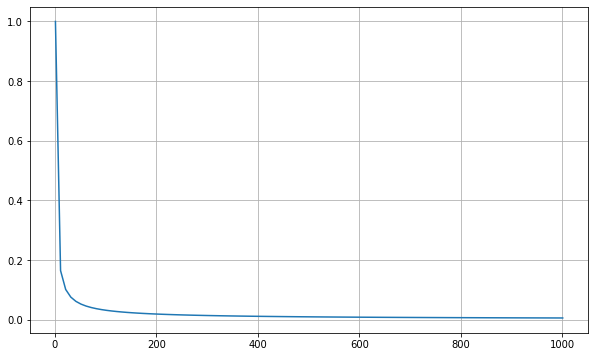

In [135]:
fig = plt.figure()
ax = fig.add_subplot(111)

gm = 0.75
l = False
x = np.linspace(1,n+1,100)
if l:
    y = [np.log(i**(-gm)) for i in x]
else:
    y = [i**(-gm) for i in x]
ax.plot(x,y)
ax.grid()

[0.001998001998001998,
 0.052947052947052944,
 0.052947052947052944,
 0.04295704295704296,
 0.03896103896103896,
 0.04295704295704296,
 0.04595404595404595,
 0.03296703296703297,
 0.03796203796203796,
 0.03696303696303696,
 0.03396603396603397,
 0.027972027972027972,
 0.028971028971028972,
 0.01898101898101898,
 0.014985014985014986,
 0.01998001998001998,
 0.016983016983016984,
 0.008991008991008992,
 0.016983016983016984,
 0.01098901098901099,
 0.02097902097902098,
 0.007992007992007992,
 0.013986013986013986,
 0.01098901098901099,
 0.01098901098901099,
 0.01098901098901099,
 0.005994005994005994,
 0.007992007992007992,
 0.012987012987012988,
 0.008991008991008992,
 0.004995004995004995,
 0.01098901098901099,
 0.008991008991008992,
 0.006993006993006993,
 0.001998001998001998,
 0.006993006993006993,
 0.002997002997002997,
 0.007992007992007992,
 0.003996003996003996,
 0.006993006993006993,
 0.003996003996003996,
 0.00999000999000999,
 0.005994005994005994,
 0.004995004995004995,
 0.00

{1: 2,
 2: 53,
 3: 53,
 4: 43,
 5: 39,
 6: 43,
 7: 46,
 8: 33,
 9: 38,
 10: 37,
 11: 34,
 12: 28,
 13: 29,
 14: 19,
 15: 15,
 16: 20,
 17: 17,
 18: 9,
 19: 17,
 20: 11,
 21: 21,
 22: 8,
 23: 14,
 24: 11,
 25: 11,
 26: 11,
 27: 6,
 28: 8,
 29: 13,
 30: 9,
 31: 5,
 32: 11,
 33: 9,
 34: 7,
 35: 2,
 36: 7,
 37: 3,
 38: 8,
 39: 4,
 40: 7,
 41: 4,
 42: 10,
 43: 6,
 44: 5,
 45: 4,
 46: 3,
 47: 1,
 48: 3,
 49: 2,
 50: 5,
 51: 4,
 52: 4,
 53: 3,
 55: 5,
 56: 1,
 57: 2,
 58: 3,
 60: 3,
 62: 3,
 64: 5,
 65: 3,
 66: 5,
 67: 2,
 68: 5,
 69: 5,
 70: 2,
 71: 4,
 72: 2,
 73: 3,
 75: 1,
 76: 4,
 77: 2,
 78: 2,
 79: 5,
 81: 2,
 82: 3,
 84: 3,
 85: 4,
 86: 1,
 87: 1,
 88: 3,
 89: 1,
 90: 1,
 91: 1,
 92: 4,
 93: 2,
 95: 2,
 96: 2,
 100: 4,
 101: 1,
 102: 2,
 103: 3,
 104: 3,
 105: 5,
 106: 1,
 108: 2,
 109: 3,
 110: 2,
 111: 4,
 112: 1,
 114: 2,
 115: 1,
 118: 1,
 119: 2,
 121: 4,
 122: 2,
 123: 3,
 124: 1,
 126: 2,
 128: 1,
 129: 1,
 130: 1,
 131: 1,
 132: 1,
 133: 1,
 134: 1,
 135: 3,
 136: 2,
 138: 2,


ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [161]:
[count/len(degs(gm)) for deg, count in deg_counts.items()]

AttributeError: 'zip' object has no attribute 'items'

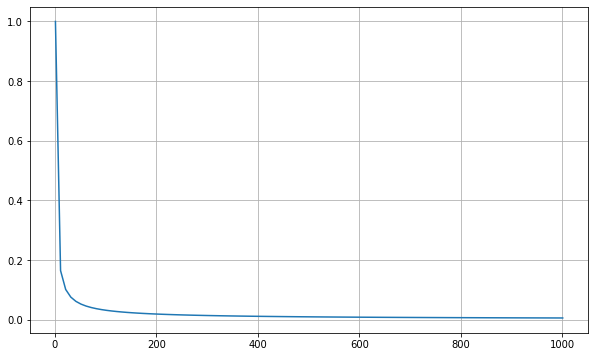

In [135]:
if l:
    y = [np.log(i**(-gm)) for i in x]
else:
    y = [i**(-gm) for i in x]
ax.plot(x,y)
ax.grid()

In [42]:
d

['622,1157',
 '623,1088',
 '624,1169',
 '625,1169',
 '626,984',
 '627,1322',
 '628,1178',
 '629,1103',
 '630,1211',
 '631,1292',
 '632,1124',
 '633,1171',
 '634,1133',
 '635,1227',
 '636,1142',
 '637,1216',
 '638,1259',
 '639,1299',
 '640,1232',
 '641,1117',
 '642,1155',
 '643,1232',
 '644,1083',
 '645,1020',
 '646,1394',
 '647,1196',
 '648,1148',
 '649,1083',
 '650,1189',
 '651,1133',
 '652,1034',
 '653,1157',
 '654,1034',
 '655,1097',
 '656,1299',
 '657,1157',
 '658,1130',
 '659,1155',
 '660,1349',
 '661,1232',
 '662,1103',
 '663,1103',
 '664,1083',
 '665,1027',
 '666,1166',
 '667,1148',
 '668,1250',
 '669,1155',
 '670,1047',
 '671,1054',
 '672,1018',
 '673,1189',
 '674,1126',
 '675,1250',
 '676,1297',
 '677,1178',
 '678,1043',
 '679,1103',
 '680,1250',
 '681,1272',
 '682,1169',
 '683,1004',
 '684,1083',
 '685,1164',
 '686,1124',
 '687,1027',
 '688,995',
 '689,1169',
 '690,1270',
 '691,1011',
 '692,1247',
 '693,1101',
 '694,1004',
 '695,1004',
 '696,1065',
 '697,1223',
 '698,1184',
 

In [28]:
nile = [float(x) for x in d.replace('\n', ' ').split(' ') if x]

In [22]:
x = range(622, 1284+1)
assert len(nile) == len(x)

In [36]:
with open('nile.txt', 'w+') as f:
    f.write('# nile river annual minimum level, annually, years 622-1284\n')
    f.write('# from the R longmemo package, see https://cran.r-project.org/package=longmemo \n')
    f.write('# year,level \n')
    for year, y in zip(x, nile):
        f.write(f"{year},{int(y)}\n")

In [37]:
!cat nile.txt

# nile river annual minimum level, annually, years 622-1284
# from the R longmemo package, see https://cran.r-project.org/package=longmemo 
# year,level 
622,1157
623,1088
624,1169
625,1169
626,984
627,1322
628,1178
629,1103
630,1211
631,1292
632,1124
633,1171
634,1133
635,1227
636,1142
637,1216
638,1259
639,1299
640,1232
641,1117
642,1155
643,1232
644,1083
645,1020
646,1394
647,1196
648,1148
649,1083
650,1189
651,1133
652,1034
653,1157
654,1034
655,1097
656,1299
657,1157
658,1130
659,1155
660,1349
661,1232
662,1103
663,1103
664,1083
665,1027
666,1166
667,1148
668,1250
669,1155
670,1047
671,1054
672,1018
673,1189
674,1126
675,1250
676,1297
677,1178
678,1043
679,1103
680,1250
681,1272
682,1169
683,1004
684,1083
685,1164
686,1124
687,1027
688,995
689,1169
690,1270
691,1011
692,1247
693,1101
694,1004
695,1004
696,1065
697,1223
698,1184
699,1216
700,1180
701,1142
702,1277
703,1206
704,1076
705,1076
706,1189
707,1121
708,1178
709,1031
710,1076
711,1178
712,1209
713,1022
714,1220
715,1070
71